# Decision Tree를 기반으로 한 Titanic 생존자 예측

이 kernel은 ' https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy ' 을 참고하고 변형하여 작성하였습니다.

## 목차
* 1. 문제인식 및 Library 설치
* 2. 데이터 정비  
    * 2-1 변수설명  
    * 2-2 4가지 Data Cleaning  
* 3. EDA with statistics  
    * 3-1 다양한 그래프를 이용하여 변수들과 Survived의 관계파악
* 4. Model Data  
    * 4-1. 우리만의 Tree 모형 만들어보기  
    * 4-2. CV를 이용한 모델 수행 및 Hyper-Parameter Tuning  
        * 4-2-1. Decision Tree를 바탕으로 한 Hyper-Parameter Tuning
        * 4-2-2. Feature선택을 바탕으로한 모델 Tuning
    * 4-3. Decision Tree 시각화(White Box)

## 1. 문제 인식 및 Library 설치
* RMS 타이타닉호는 역사상 악명 높은 난파선 중 하나이며 1912년 4월 15일 타이타닉호는 빙산과 충돌한 후 침몰하여 2224명 중 1502명이 사망했다.
* 난파선이 이런 인명피해를 낸 이유 중 하나는 구명보트가 부족했기 때문이었다. 침몰에서 살아남는데 행운의 요소가 어느 정도 포함되었지만 여성, 아동, 상류층 등 다른 집단보다 생존 가능성이 더 높은 집단이 있었다.
* 이번 challenge에서는 어떤 종류 혹은 집단의 사람들이 살아남을 것 같았는지 부석을 하는 것이다. 특히 이 참사에서 살아남은 승객이 누구인지 예측하기 위해서 Machine Learning을 사용하여 예측해보도록 한다.
* **이번 문제는 생존을 했는지 안했는지를 예측하는 문제로 binary classification문제로 접근하였다.**

**Note :** 이번 challenge는 Kaggle에서 주어지는 꽤나 깔끔한 데이터를 사용하였으며 감사하게도 Data architecture, governance, and extraction과 같은 처리는 해주지 않았으며 Data cleaning 위주로 진행하였다.

In [1]:
import sys
import pandas as pd
import numpy as np
import scipy as sp
import IPython
import sklearn
import matplotlib

import random
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble,\
 discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix
%matplotlib inline

mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12, 8

## 2. 데이터 준비

### 2-1. 변수설명
* 먼저, 이름을 통해 데이터를 파악하고 데이터에 대하여 자세히 알아보도록 한다. (예를 들어, 데이터의 타입이 어떻게 생겼는지 혹은 독립형 변수인지 의존형 변수인지를 알아본다.)

1. Survived : 생존한 것이 1, 생존하지 못한 것이 0, 이진 데이터.
2. PassengerID : 결과에 영향을 미치지 않는 고유식별자. 분석에서 사용하지 않는다.
3. Pclass : 순서형 데이터. 사회경제적 지위를 나타내며 (1:상위, 2:중간, 3:하위)를 나타낸다.
4. Name : 명목형 변수로, 이 변수는 feature engineering을 통해 가족크기 혹은 지위에 대한 타이틀을 도출할 수 있다. 
5. Sex & Embarked : 성별과 탑승위치는 명목형 데이터로 dummy 변수로 변환시켜 사용하도록 한다.
6. Age & Fare : 나이와 요금은 연속형 양적 데이터이다.
7. SibSp & Parch: 탑승자의 형제 자매수, 부모자녀수를 나타낸다. 둘다 이산적 quantitative 데이터이다. 가족의 크기를 만들 때 사용할 수 있으며, 가변적이다.
8. Cabin : 사고가 발생했을 때 선박의 대략적인 위치를 나타낸다. Null값이 많기 때문에 사용하지 않기로 한다.

In [4]:
data_raw = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')

X_train = data_raw.copy()
combine = [X_train, X_test]


# 데이터의 형태를 파악하며
# 샘플을 이용하여 10개만 추출하여 DataFrame이 어떻게 생격는지 확인한다.
print(data_raw.info())
data_raw.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
237,238,1,2,"Collyer, Miss. Marjorie ""Lottie""",female,8.0,0,2,C.A. 31921,26.2500,NaN,S
389,390,1,2,"Lehmann, Miss. Bertha",female,17.0,0,0,SC 1748,12.0000,NaN,C
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
41,42,0,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.0,1,0,11668,21.0000,NaN,S
321,322,0,3,"Danoff, Mr. Yoto",male,27.0,0,0,349219,7.8958,NaN,S
621,622,1,1,"Kimball, Mr. Edwin Nelson Jr",male,42.0,1,0,11753,52.5542,D19,S
521,522,0,3,"Vovk, Mr. Janko",male,22.0,0,0,349252,7.8958,NaN,S
864,865,0,2,"Gill, Mr. John William",male,24.0,0,0,233866,13.0000,NaN,S
823,824,1,3,"Moor, Mrs. (Beila)",female,27.0,0,1,392096,12.4750,E121,S
212,213,0,3,"Perkin, Mr. John Henry",male,22.0,0,0,A/5 21174,7.2500,NaN,S


### 2-2. 4가지 Data Cleaning : Correcting, Completing, Creating, Converting

* **Correcting** : 이상치 및 특이치 수정. **데이터 검토**를 통해 잘못된 데이터나 허용되지 않는 데이터가 있는지 확인(현재 데이터에서는 없는 것으로 나타난다.) 수정의 경우 분명히 나이나 요금처럼 특이치를 가질 것으로 보이는 column이 있지만 성급히 수정하지 않고 EDA를 하고나서 확인한 후 수정하도록 한다.
* **Completing** : Missing 정보 완성. 보통 Missing Value를 채우는 것으로써는 **삭제** 혹은 **합리적인 입력값 입력**이 있다. **(질적데이터 : mode, 정량데이터 : mean 혹은 mid 혹은 mean + 표준편차)** 일단은 기본적은 방법으로 결측값을 채우도록 한다. 물론 더 복잡한 방법이 있지만 기본적인 방법으로 결측값을 채운 후에 분석을 진행한 후 정확도를 높이기 위해서 수정하도록 한다.
* **Creating** : 새로운 feature 만들기. 기존 feature를 사용하여 새로운 feature를 만든다.
* **Converting** : 데이터 정리. 현 데이터는 범주형 데이터로 되어있어 수학적 계산하기 어렵기 때문에 dummy변수로 변환하여 계산을 해주도록 한다.

In [5]:
# Null 값이 있는지 확인해보도록 한다.

print('Train columns with null values : \n',
      X_train.isnull().sum())
print('-'*40)

print('Test/Validation columns with null values : \n',
      X_test.isnull().sum())
print('-'*40)

Train columns with null values : 
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------------------------------------
Test/Validation columns with null values : 
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------------------------------------


#### Completing : 결측치 처리
* Age : 중앙값으로 처리
* Embarked : 최빈값으로 처리
* Fare : 중앙값으로 처리
* Cabin & Ticket : drop 처리

In [6]:
# Train Set과 TestSet 모두 결측치를 처리해준다.
# Age는 중앙값, Embarked는 최빈값, Fare는 중앙값으로 처리한다.
# 고유값을 나타내는 PassengerId, 많은 결측치를 가지고 있는 Cabin, 티켓번호를 나타내는 Ticket은 Drop해주도록 한다.

for data in combine :
    data['Age'].fillna(data['Age'].median(), inplace = True)
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace = True)
    data['Fare'].fillna(data['Fare'].median(), inplace = True)
    
col = ['PassengerId', 'Cabin', 'Ticket']
X_train.drop(col, axis = 1, inplace = True)

print(X_train.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


#### Creating : 새로운 변수 만들기 
* FamilySize : '형제자매수 + 부모자녀수 + 나'로 계산하여 가족의 크기를 게산한다.
* IsAlone : 가족수가 1명이면 1 아니면 0으로 표현한다.
* Title : 'Name'변수로 부터 ['Mr', 'Mrs', 'Miss']와 같은 title을 가져와 새로운 변수로 만들어준다.
    * Title의 경우 10개보다 적은 Title은 Misc로 통일시켜준다.
* FareBin : 'Fare'변수를 4분위수로 나뉘어 4분할된 값을 새로운 변수로 가진다.
* AgeBin : 'Age'변수를 min_max가 5분할된 값을 새로운 변수로 가진다.

In [7]:
for data in combine :
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    
    data['IsAlone'] = 1
    data['IsAlone'].loc[data['FamilySize'] > 1] = 0
    
    data['Title'] = data['Name'].str.split(", ", expand = True)[1].str.split('.', expand = True)[0]
    
    data['FareBin'] = pd.qcut(data['Fare'], 4)
    
    data['AgeBin'] = pd.cut(data['Age'].astype(int), 5)
    
title_names = (X_train['Title'].value_counts() < 10)
X_train['Title'] = X_train['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(X_train['Title'].value_counts())
print('-'*40)

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
----------------------------------------


#### Converting : LabelEncoding을 활용하여 명목형 변수를 숫자형 변수로 만들어주기

In [8]:
label = LabelEncoder()

for data in combine :
    data['Sex_Code'] = label.fit_transform(data['Sex'])
    data['Embarked_Code'] = label.fit_transform(data['Embarked'])
    data['Title_Code'] = label.fit_transform(data['Title'])
    data['AgeBin_Code'] = label.fit_transform(data['AgeBin'])
    data['FareBin_Code'] = label.fit_transform(data['FareBin'])

In [9]:
# 이후에 Tree모형에 사용해줄 칼럼들만 사용하여 X_train1에 입력해주도록 한다.
col = ['Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code',
       'AgeBin_Code', 'FareBin_Code', 'FamilySize', 'IsAlone']

X_train1 = X_train[col]

In [10]:
# EDA에 사용할 칼럼들만 col2에 입력해주도록 한다.
col2 = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
        'Embarked', 'FamilySize', 'IsAlone', 'Title']

## 3. EDA with statistics

변수를 설명하고 요약할 수 있는 기술 통계와 그래프로 데이터를 탐색해 보도록 하자. feature 분류와 변수간의 상관관계를 파악할 수 있다.

In [11]:
for x in col2 :
    if X_train[x].dtype != 'float64' :
        print('Survival Correleation by: ', x)
        print(X_train[[x, 'Survived']].groupby(x, as_index = False).mean())
        print('-'*40, '\n')
        
print(pd.crosstab(X_train['Title'], X_train['Survived']))

Survival Correleation by:  Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------------------------------------- 

Survival Correleation by:  Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------------------------------------- 

Survival Correleation by:  SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------------------------------------- 

Survival Correleation by:  Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------------------------------------- 

Survival Correleation by:  Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------------------------------------- 

Survival Correleation by:  FamilySize
   FamilySize  Survived
0           1  0.303538
1   

### 3-1. 다양한 그래프를 이용하여 변수들과 Survived의 관계파악


#### Fare, Age, FamilySize와 Survived와의 관계 Plotting

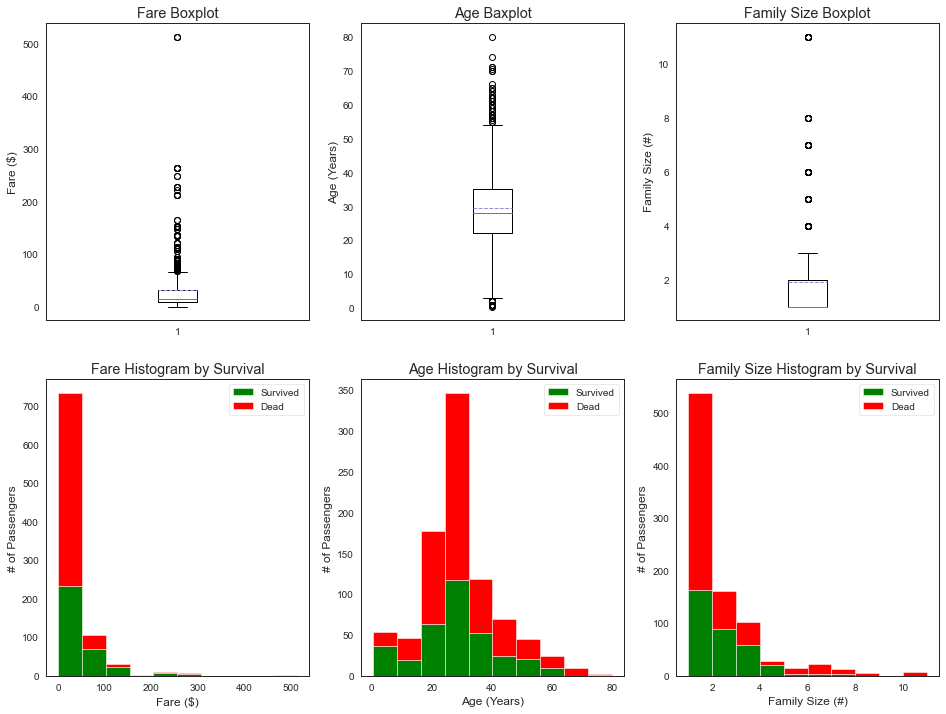

In [12]:
plt.figure(figsize = [16, 12])

plt.subplot(231)
plt.boxplot(x = X_train['Fare'], showmeans = True, meanline = True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(X_train['Age'], showmeans = True, meanline = True)
plt.title('Age Baxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(X_train['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x = [X_train[X_train['Survived'] == 1]['Fare'],
              X_train[X_train['Survived'] == 0]['Fare']],
         stacked = True, color = ['g', 'r'], label = ['Survived', 'Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [X_train[X_train['Survived'] == 1]['Age'],
              X_train[X_train['Survived'] == 0]['Age']],
         stacked = True, color = ['g', 'r'], label = ['Survived', 'Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [X_train[X_train['Survived'] == 1]['FamilySize'],
              X_train[X_train['Survived'] == 0]['FamilySize']],
         stacked = True, color = ['g', 'r'], label = ['Survived', 'Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()


#### Embarked, IsAlone, FareBin과 Survived의 관계 Plotting

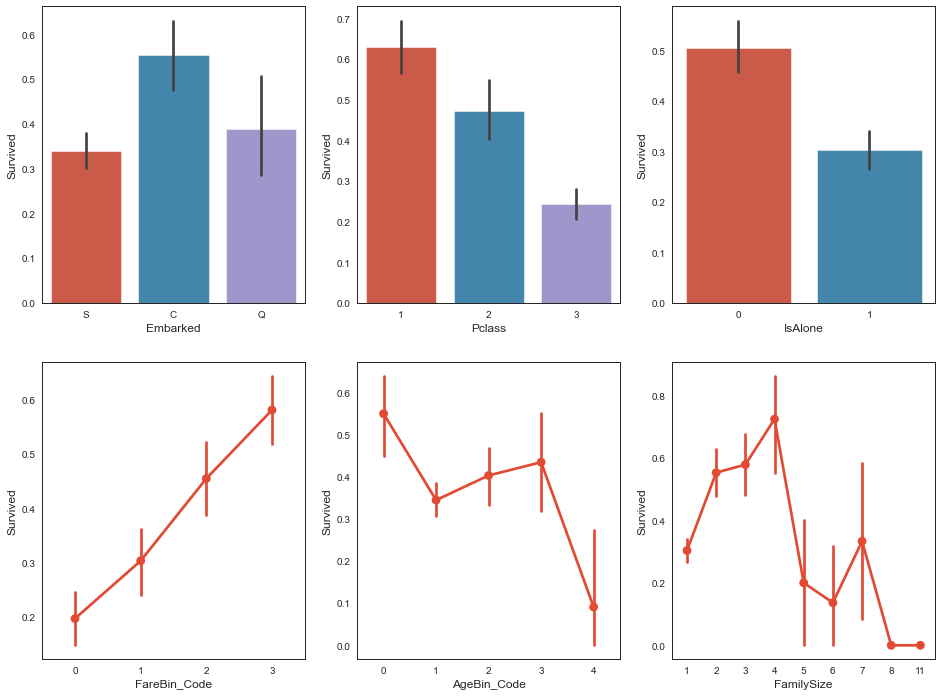

In [13]:
fig, saxis = plt.subplots(2, 3, figsize = (16, 12))

sns.barplot(x = 'Embarked', y = 'Survived',
            data = X_train, ax = saxis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived',
            data = X_train, ax = saxis[0,1])
sns.barplot(x = 'IsAlone', y = 'Survived',
            data = X_train, ax = saxis[0,2])

sns.pointplot(x = 'FareBin_Code', y = 'Survived', 
              data = X_train, ax = saxis[1,0])
sns.pointplot(x = 'AgeBin_Code', y = 'Survived',
              data = X_train, ax = saxis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived',
              data = X_train, ax = saxis[1,2])

#### Pclass와 Fare, Age, FamilySize사이의 관계파악

Text(0.5, 1.0, 'Pclass vs FamilySize Survival Comparison')

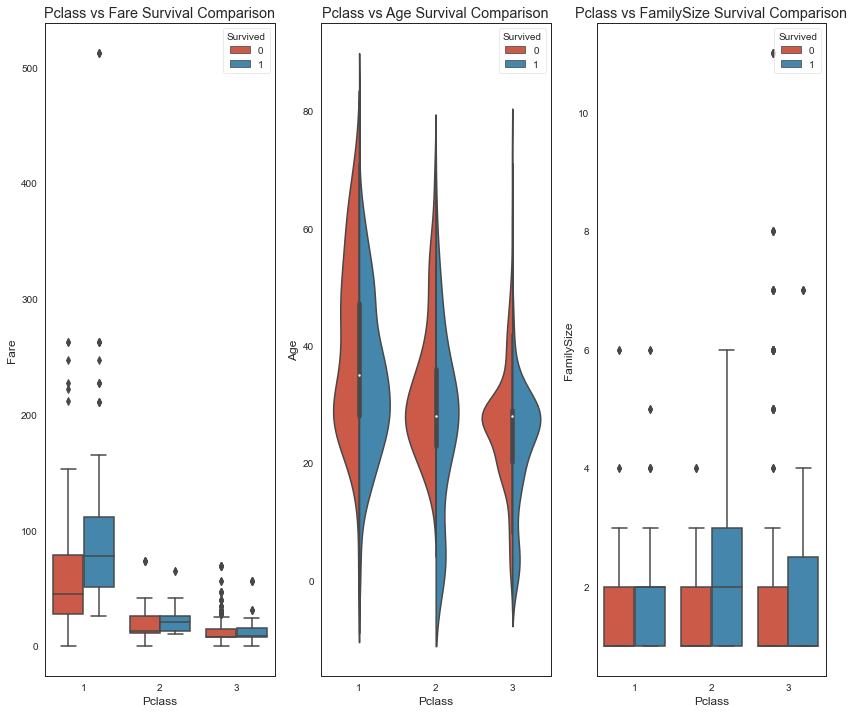

In [14]:
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize = (14, 12))

sns.boxplot(x = 'Pclass', y = 'Fare', hue = 'Survived',
            data = X_train, ax = axis1)
axis1.set_title('Pclass vs Fare Survival Comparison')

sns.violinplot(x = 'Pclass', y = 'Age', hue = 'Survived',
            data = X_train, split = True, ax = axis2)
axis2.set_title('Pclass vs Age Survival Comparison')

sns.boxplot(x = 'Pclass', y = 'FamilySize', hue = 'Survived',
            data = X_train, ax =  axis3)
axis3.set_title('Pclass vs FamilySize Survival Comparison')


#### Sex와 Survival의 관계에서 Embarked, Pclass, IsAlone별로 나타내기


Text(0.5, 1.0, 'Sex vs IsAlone Survival Comparison')

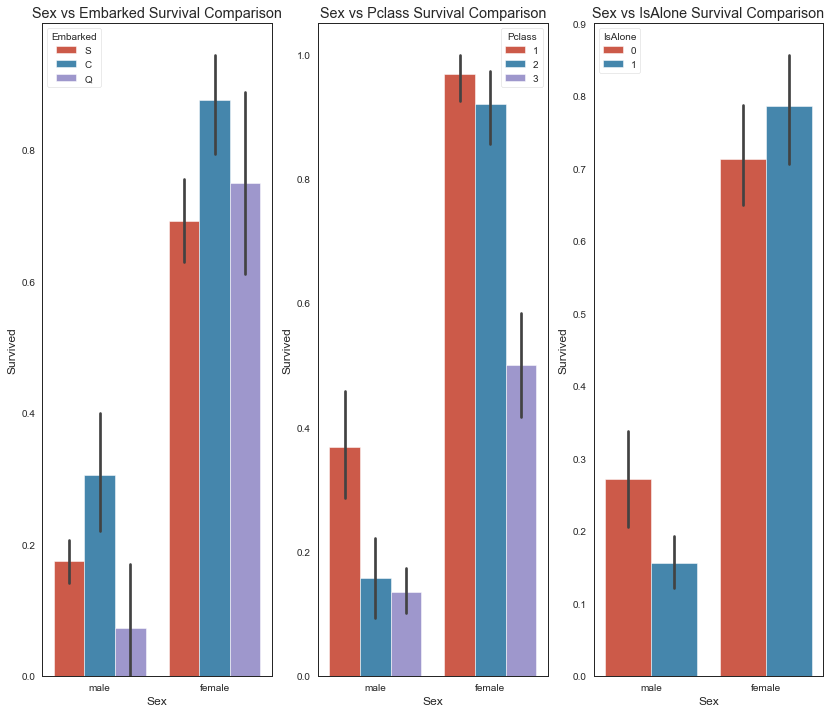

In [15]:
fig, qaxis = plt.subplots(1, 3, figsize = (14, 12))

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Embarked',
            data = X_train, ax = qaxis[0])
qaxis[0].set_title('Sex vs Embarked Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Pclass',
            data = X_train, ax= qaxis[1])
qaxis[1].set_title('Sex vs Pclass Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'IsAlone',
            data =X_train, ax = qaxis[2])
qaxis[2].set_title('Sex vs IsAlone Survival Comparison')


#### Familysize, Pclass와 Survived사이의 관계에서 성별별로 나타내기


Text(0.5, 1.0, 'Pclass vs Sex Survived Comparison')

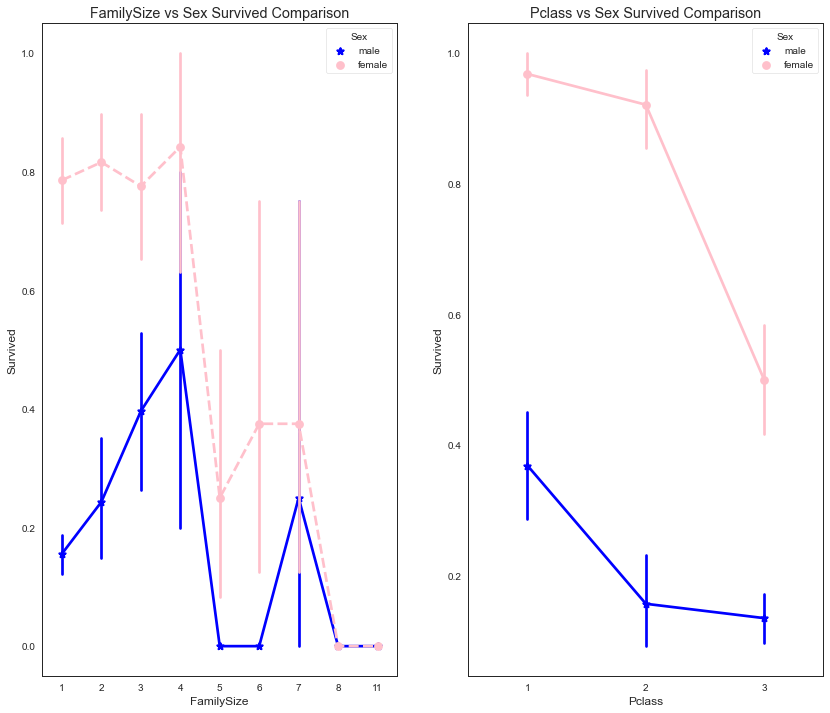

In [16]:
fig, (maxis1, maxis2) = plt.subplots(1, 2, figsize = (14, 12))

sns.pointplot(x = 'FamilySize', y = 'Survived', hue = 'Sex',
              data = X_train, palette = {'male' : 'blue', 'female' : 'pink'},
              markers = ['*', 'o'], linestyles = ['-', '--'], ax = maxis1)
maxis1.set_title('FamilySize vs Sex Survived Comparison')

sns.pointplot(x = 'Pclass', y = 'Survived', hue = 'Sex',
              data = X_train, palette = {'male' : 'blue', 'female' : 'pink'},
              markers = ['*', 'o'], linesytles = ['-', '--'], ax = maxis2)
maxis2.set_title('Pclass vs Sex Survived Comparison')

#### Embarked와 Pclass사이의 관계를 성별별로 나타내기

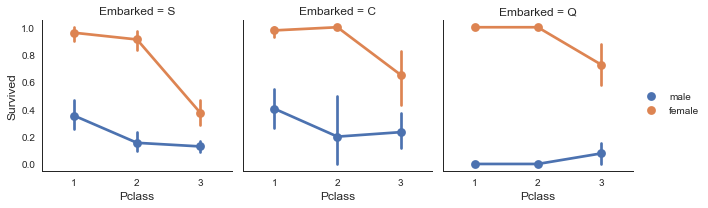

In [17]:
e = sns.FacetGrid(X_train, col = 'Embarked')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', 
      ci = 95.0, palette = 'deep', hue_order = ['male', 'female'])
e.add_legend()

#### 나이별 생존자를 kdeplot으로 나타내기

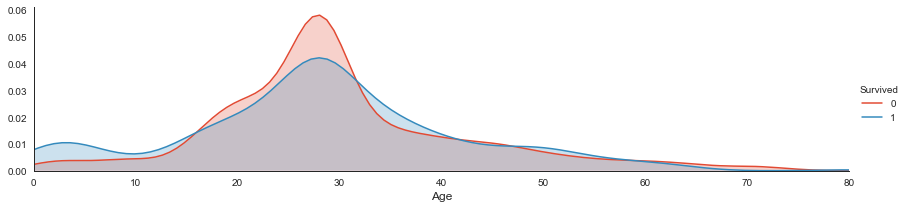

In [18]:
a = sns.FacetGrid(X_train, hue = 'Survived', aspect = 4)
a.map(sns.kdeplot, 'Age', shade = True)
a.set(xlim = (0, X_train['Age'].max()))
a.add_legend()

#### Sex, Pclass, Age별 생존자 비교


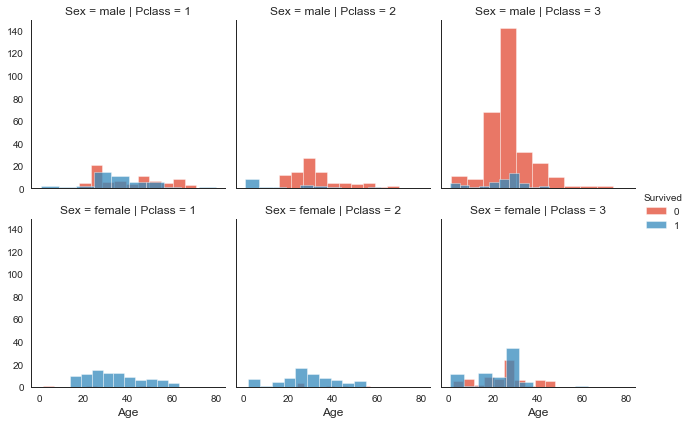

In [19]:
h = sns.FacetGrid(X_train, row = 'Sex', col = 'Pclass', hue = 'Survived')
h.map(plt.hist, 'Age', alpha = .75)
h.add_legend()

#### 전체 데이터셋에 대한 Pair Plot

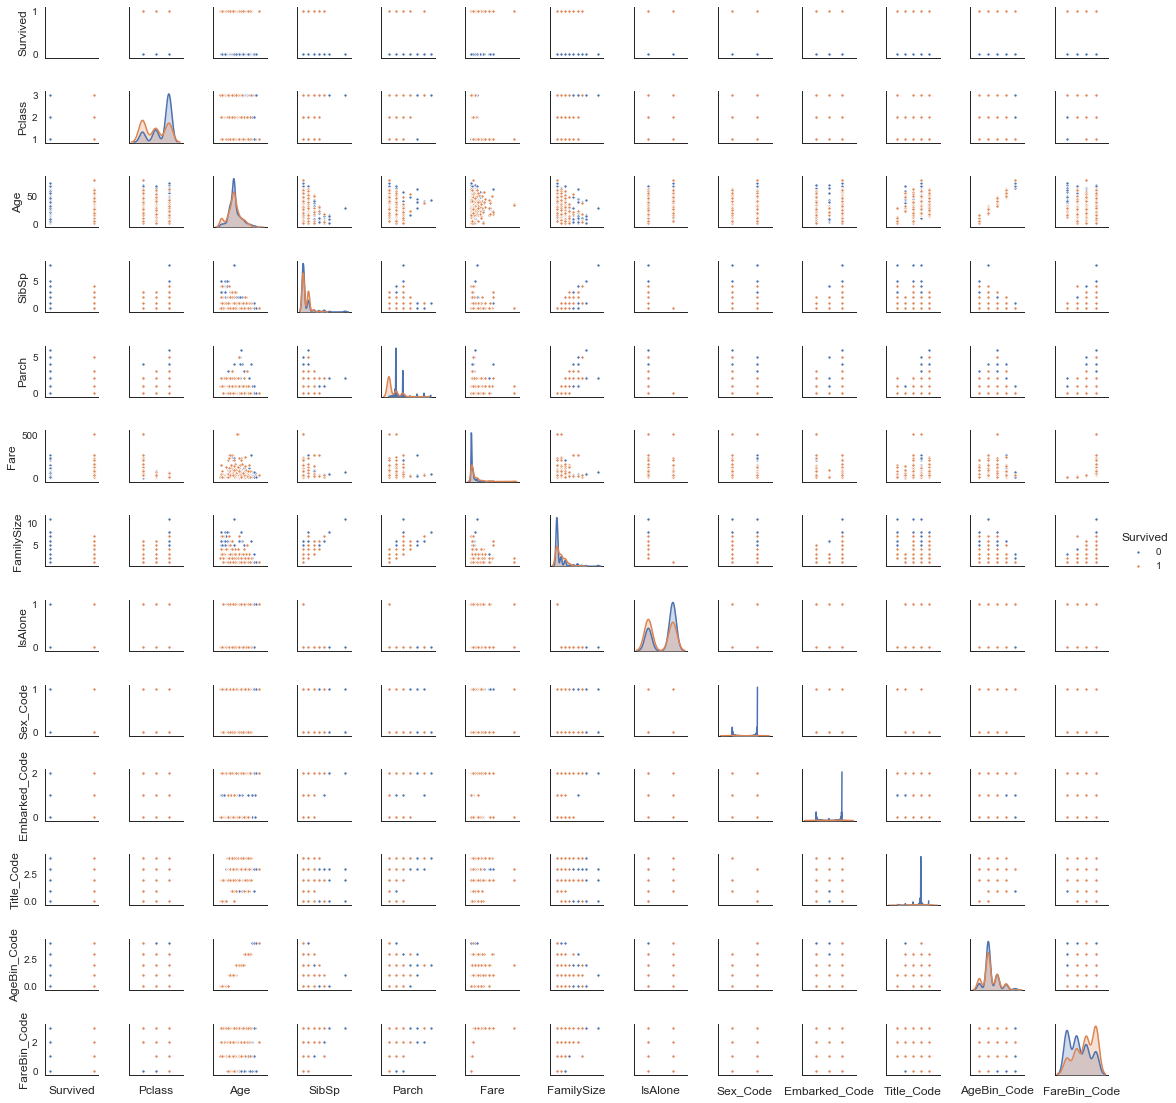

In [52]:
pp = sns.pairplot(X_train, hue = 'Survived', palette = 'deep',
                  size = 1.2, diag_kind= 'kde', diag_kws = dict(shade = True),
                  plot_kws = dict(s = 10))
pp.set(xticklabels = [])

#### 데이터셋의 상관관계를 Heatmap으로 한눈에 보기

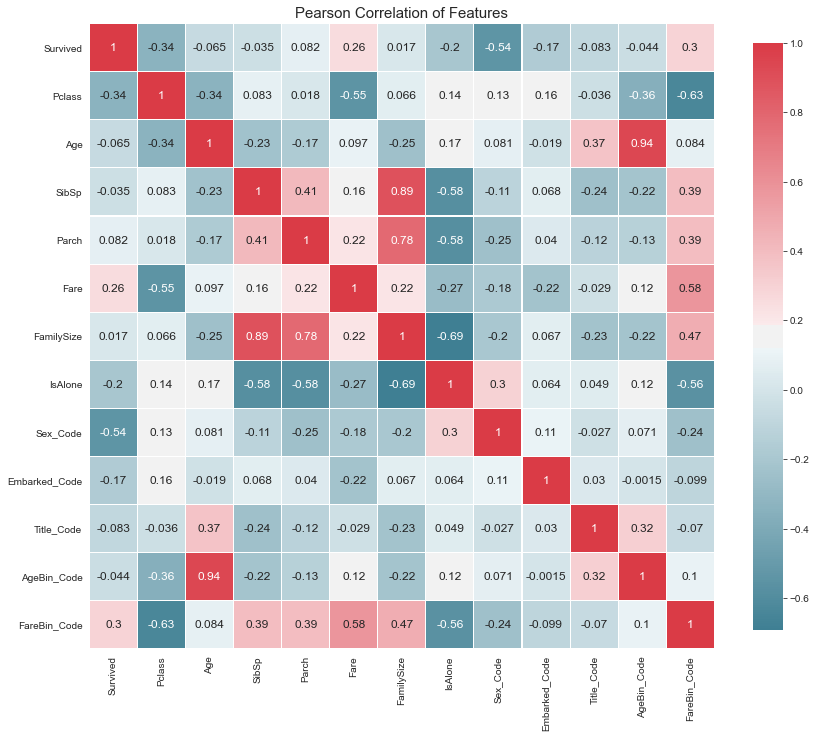

In [20]:
def correlation_heatmap(df) :
    _ , ax = plt.subplots(figsize = (14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(),
        cmap = colormap,
        square = True,
        cbar_kws = {'shrink' : .9},
        ax = ax,
        annot = True,
        linewidths = 0.1, vmax = 1.0, linecolor = 'white',
        annot_kws = {'fontsize' : 12}
    )
    
    plt.title('Pearson Correlation of Features', y = 1.05, size = 15)
    
    
correlation_heatmap(X_train)

## 4. Model Data


* ML의 경우 **감독(지도)학습**( 정답이 포함된 데이터를 학습 ), **비지도학습**( 정답이 없이 데이터를 학습 ), **강화학습**( 앞 두가지를 혼합시킨 것, 일련의 사건 후에 정답을 준다. )

* ML Algorithm은 4가지 범주로 축소할 수 있는데 **분류, 회귀, 클러스터링, 차원 감소**가 있다. 여기에서는 회귀와 분류에 초점을 맞추도록 한다.(**연속 변수의 경우 회귀 알고리즘**이, **이산 변수의 경우 분류 알고리즘**이 필요하다.)

* 생존자를 예측하는 것은 **분류문제**이므로 **분류알고리즘**을 사용하여 문제를 해결해 나가도록 하자.

**Note :** ML Algorithm 선택방법

* MLA의 경우 모든 데이터 셋에 대하여 가장 적합한 알고리즘은 없으므로 **여러개의 MLA를 시도한 후 가장 적절한 것을 선택**하는 것이 가장 좋다.  
* 그렇다고 무작정 시작하는 것보다는 **처음에는 Trees, Bagging, Random Forests, and Boosting으로 시작하는 것이 보다 좋다.** 위의 언급한 MLA들은 서로 다른 의사결정 도구이며 처음에 시도하기 좋은 알고리즘이다.  
* 여기서는 여러 MLA들을 시도해보며, 튜닝의 경우는 **Decision Tree와 이로부터 파생된 모델링 학습에 초점을 맞춰 정확도를 높이도록 할 것이다.**

### 4-1. 우리만의 Tree 모형 만들어보기

**Note :** **먼저 기준 정확도를 정해야한다.**   
우리는 2224명 중 1502명이 죽었다는 것을 알고 있으며 67.5%에 해당한다. 그러므로 우리가 100% 사망을 예측한다고 할 때 사망률은 67.5%가 옳은 값일 것이다. 그러므로 68% 이상이 나오는 것은 불량 모델 성능으로 설정하도록 하자.

**Note : 자신만의 모델을 만들자**  
여기서는 우리가 우리들만의 tree model을 직접 만들어볼 것이다. Decision Tree를 직접 구현할 떄는 target을 나눌 수 있는 몇몇 질문들을 해서 구현할 수 있다. 각 질문에 대하여 50%가 넘으면 1을 50%보다 낮으면 0을 입력하여 의사결정을 하도록 한다.

* 질문 1  : 타이타닉호에 있었나요?
* 질문 2  : 너는 남자니 여자니?
* 질문 3A : 너는 클래스 1,2,3 중 어디에 있었니?
* 질문 4A : 너는 Embarked의 C,Q,S 중 어디에 있었니?  
* 위와 같이 질문을 나열하도록 한다.


위와 같이 질문을 트리형식으로 내려가서 의사결정을 하는 것이 Decision Tree의 기본구조이다. 코딩을 하는데 있어서 이렇게까지 할 필요는 없지만 Decision Tree의 구조를 제대로 파악하기 위해서 직접 질문으로부터 파생된 Decision Tree를 코딩으로 구현해 보도록 하자.

In [24]:
def mytree(df) :
    
    Model = pd.DataFrame(data = {'Predict' : []})
    male_title = ['Master']
    
    for index, row in df.iterrows() :
        
        # Question 1 : Were you on Titanic
        Model.loc[index, 'Predict'] = 0
        
        # Question 2 : Are you female
        if (df.loc[index, 'Sex'] == 'female') :
            Model.loc[index, 'Predict'] = 1
            
        # Question 5B Female = FareBin
        if ((df.loc[index, 'Sex'] == 'female') &
            (df.loc[index, 'Pclass'] == 3) &
            (df.loc[index, 'Embarked'] == 'S') &
            (df.loc[index, 'Fare'] > 8)) :
            Model.loc[index, 'Predict'] = 0
            
        # Question 3B Male : Title
        if ((df.loc[index, 'Sex'] == 'male') &
            (df.loc[index, 'Title'] in male_title)) :
            Model.loc[index, 'Predict'] = 1
            
    return Model

Tree_Predict = mytree(X_train)
print('mytree 정확도: {:.2f} \n'.\
      format(metrics.accuracy_score(X_train['Survived'], Tree_Predict) ))


mytree 정확도: 0.82 



#### 그래프에 Plotting하여 정확도 요약하기
* Confusion Matrix 계산하기
* Non-Normalized Confusion Matrix Plotting하기
* Normalized Confusion Matrix Plotting하기

Confusion matrix, without normalization
[[497  52]
 [108 234]]


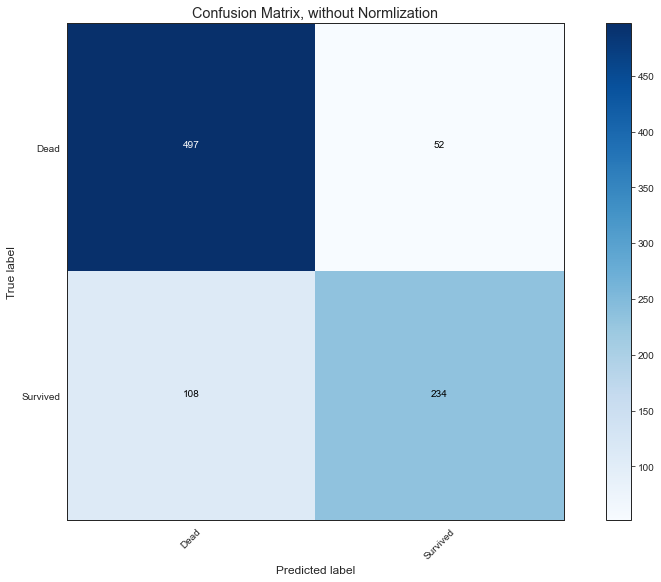

In [28]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues) :
    if normalize :
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print('Normalized confusion matrix')
    
    else :
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

cnf_matrix = metrics.confusion_matrix(X_train['Survived'],
                                      Tree_Predict)
np.set_printoptions(precision = 2)

class_names = ['Dead', 'Survived']

plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names,
                     title = 'Confusion Matrix, without Normlization')



### 4-2. CV를 이용한 모델 수행 및 Hyper-Parameter Tuning

* **Cross Validation Set** : 우리의 모델을 평가하기 위해서 우리는 CV Set을 이용해야하며 보통 CV Set을 사용하는 이유는 Train Set에 오버핏 되는 것을 방지하기 위해서 사용한다. 

#### 4-2-1. Decision Tree를 바탕으로 한 Hyper-Parameter Tuning

* **DT의 장점** :
    * 해석 및 이해가 쉽다. Tree들을 시각화할 수 있다.
    * DT의 경우 Data 정리를 많이 요구하지 않는다.(다만 DT의 경우 missing value에 대한 처리를 자동으로 해주진 않기 때문에 이는 참고해야한다.)
    * 수치형 데이터 그리고 범주형 데이터 모두 사용할 수 있다.
    * Multi-Output문제에도 적용할 수 있다.
    * White-Box 모델로서 논리를 더 쉽게 이해하고 설명할 수 있다.
    * 통계적 방법으로 모델을 검증할 수 있고, 이를 바탕으로 신뢰성을 설명할 수 있다.
    * 데이터의 실제 모델에 가정된 사항이 조금 위반되더라도 우수한 성능을 발휘한다.
    
    
* **DT의 단점** :
    * Overfitting이 될 수 있다. 즉, 지나치게 복잡한 트리구조가 만들어 질 수 있다.(샘플의 최소 개수 설정, 트리의 최대 깊이 설정과 같은 방법으로 Overfit을 방지해야 한다.)
    * DT의 경우 데이터의 작은 변화로 인해 완전히 다른 Tree 구조가 될 수 있으므로 불안정할 수 있다.
    * XOR, parity, multiplexer 문제 등 DT가 쉽게 표현하지 않아 배우기 어려운 개념들이 있다.
    * 데이터가 편향되어 있다면 편향된 Tree 구조가 만들어지기 쉽다. 그러므로 데이터가 편향되지 않도록 만들어줄 필요성이 있다.
    
 
* **DT API의 기본구조** :
    * class sklearn.tree.DecisionTreeClassifier(criterion=’gini’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)
    * `ParameterGrid`, `GridSearchCV`를 사용하여 모델을 튜닝할 것이다. 그리고 이후에 Tree를 시각화 해서 나타내보도록 한다.

### 4-3. Decision Tree 시각화(White Box)

In [26]:
cv_split = model_selection.ShuffleSplit(n_splits = 10,
                                        test_size = .3, train_size = .6,
                                        random_state = 0)

dtree = tree.DecisionTreeClassifier(random_state = 0)
base_results = model_selection.cross_validate(dtree, X_train1,
                                              X_train['Survived'], 
                                              cv = cv_split,
                                              return_train_score = True)
dtree.fit(X_train1, X_train['Survived'])

DecisionTreeClassifier(random_state=0)

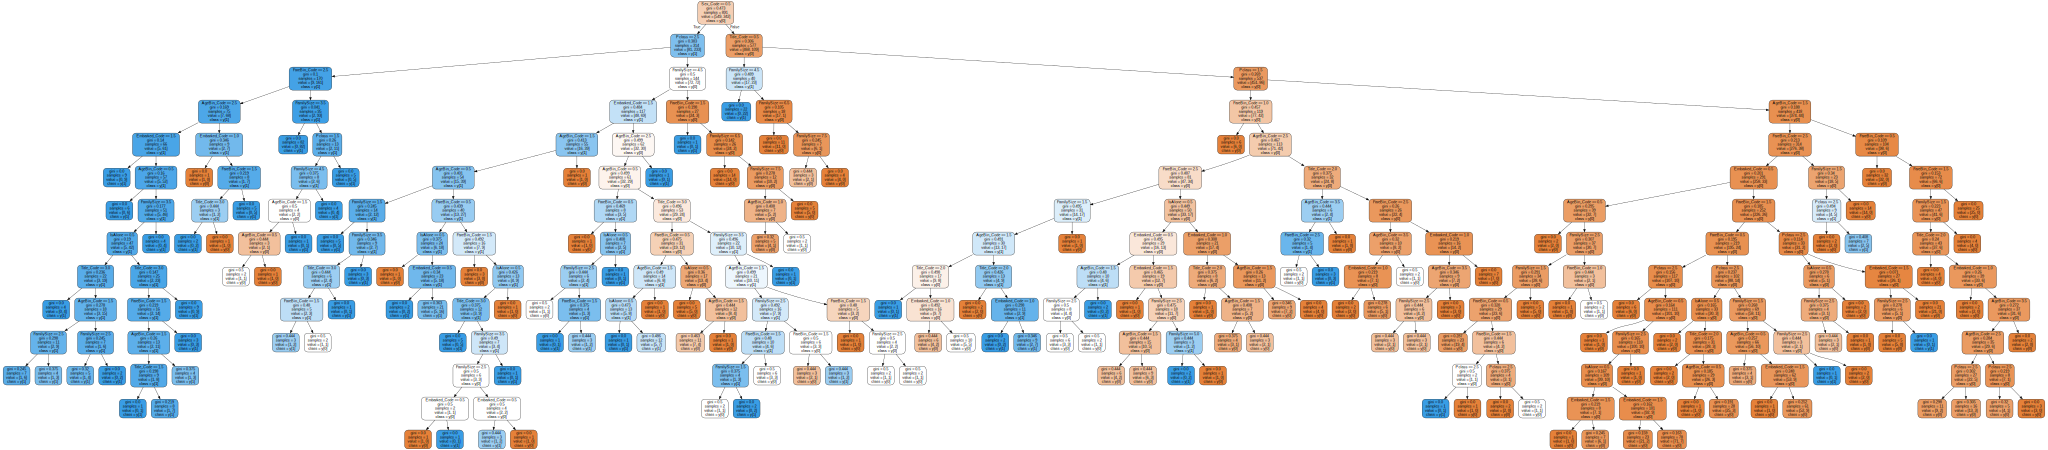

In [27]:
import graphviz

dot_data = tree.export_graphviz(dtree, out_file = None,
                                feature_names = X_train1.columns,
                                class_names = True,
                                filled = True,
                                rounded = True)
graph = graphviz.Source(dot_data)
graph

In [29]:
y_train = X_train['Survived']

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X_train1 , X_test1, y_train1, y_test1 = train_test_split(X_train1, y_train, test_size=0.3, random_state=12)

dt_clf=DecisionTreeClassifier(random_state=12)
dt_clf.fit(X_train1, y_train1)
pred = dt_clf.predict(X_test1)
accuracy = accuracy_score(y_test1,pred)
print('결정트리 예측정확도:{0:.4f}'.format(accuracy))

결정트리 예측정확도:0.7761


In [32]:
from sklearn.model_selection import GridSearchCV
params={
    'max_depth':[1,2,3,4,5,6,7,8],
    'min_samples_split':[2,3,4,5,6,7]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy',cv=5,verbose=1)
grid_cv.fit(X_train1,y_train1)
print('GridSearchCV 최고 평균 정확도 수치:{0:4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:',grid_cv.best_params_)
print(grid_cv.best_estimator_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GridSearchCV 최고 평균 정확도 수치:0.853948
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 3, 'min_samples_split': 2}
DecisionTreeClassifier(max_depth=3, random_state=12)


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    0.8s finished


In [36]:
best_df_clf=DecisionTreeClassifier(max_depth= 3, min_samples_split= 2)
best_df_clf.fit(X_train1, y_train1)
pred = best_df_clf.predict(X_test1)
accuracy = accuracy_score(y_test1,pred)
print('결정트리 예측정확도:{0:.4f}'.format(accuracy))

결정트리 예측정확도:0.7910


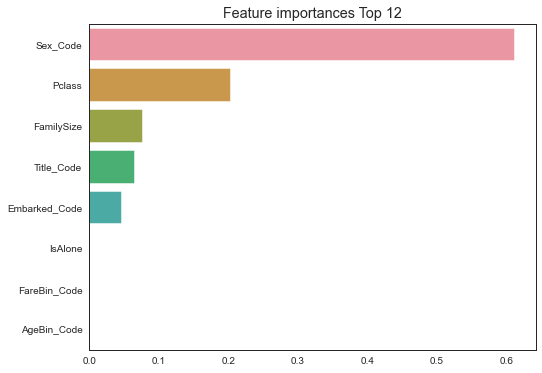

In [37]:
import seaborn as sns

ftr_importances_values = best_df_clf.feature_importances_

# Top 중요도로 정렬을 쉽게 하고, 시본(Seaborn)의 막대그래프로 쉽게 표현하기 위해 Series변환
ftr_importances = pd.Series(ftr_importances_values, index=X_train1.columns  )

# 중요도값 순으로 Series를 정렬
ftr_top12 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 12')
sns.barplot(x=ftr_top12 , y = ftr_top12.index)
plt.show()

## RandomForest

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

rf_clf =RandomForestClassifier(random_state=0)
rf_clf.fit(X_train1,y_train1)
pred = rf_clf.predict(X_test1)
accuracy=accuracy_score(y_test1,pred)
print('랜덤포레스트 정확도:{0:.2f}'.format(accuracy))

랜덤포레스트 정확도:0.77


In [40]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [8, 16, 20]
}
rf_clf = RandomForestClassifier()
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=5 )
grid_cv.fit(X_train1 , y_train1)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 100}
최고 예측 정확도: 0.8347


In [41]:
rf_clf1=RandomForestClassifier(n_estimators= 100,max_depth=6, min_samples_leaf= 8, min_samples_split= 8,random_state=0)

rf_clf1.fit(X_train1,y_train1)
pred=rf_clf1.predict(X_test1)
print('에측정확도:{0:.2f}'.format(accuracy_score(y_test1,pred)))

에측정확도:0.81


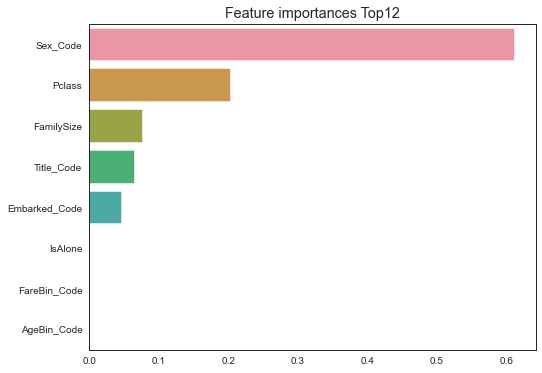

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
ftr_importances_values = rf_clf1.feature_importances_
ftr_importancees=pd.Series(ftr_importances_values, index=X_train1.columns)
ftr_top12 = ftr_importances.sort_values(ascending=False)[:12]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top12')
sns.barplot(x=ftr_top12,y=ftr_top12.index)
plt.show()

## LightGBM

In [43]:
import lightgbm
from lightgbm import LGBMClassifier

In [46]:
lgbm_wrapper = LGBMClassifier(n_estimators=400)
                                                                 
evals = [(X_test1, y_test1)]
lgbm_wrapper.fit(X_train1, y_train1, early_stopping_rounds=100, eval_metric="logloss", 
                 eval_set=evals, verbose=True)

preds = lgbm_wrapper.predict(X_test1)
pred_proba = lgbm_wrapper.predict_proba(X_test1)[:, 1]

[1]	valid_0's binary_logloss: 0.636094
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.606742
[3]	valid_0's binary_logloss: 0.582505
[4]	valid_0's binary_logloss: 0.562552
[5]	valid_0's binary_logloss: 0.548225
[6]	valid_0's binary_logloss: 0.535156
[7]	valid_0's binary_logloss: 0.525879
[8]	valid_0's binary_logloss: 0.516904
[9]	valid_0's binary_logloss: 0.5108
[10]	valid_0's binary_logloss: 0.50007
[11]	valid_0's binary_logloss: 0.492892
[12]	valid_0's binary_logloss: 0.485568
[13]	valid_0's binary_logloss: 0.480433
[14]	valid_0's binary_logloss: 0.475967
[15]	valid_0's binary_logloss: 0.472301
[16]	valid_0's binary_logloss: 0.470772
[17]	valid_0's binary_logloss: 0.469169
[18]	valid_0's binary_logloss: 0.468567
[19]	valid_0's binary_logloss: 0.467279
[20]	valid_0's binary_logloss: 0.465802
[21]	valid_0's binary_logloss: 0.46639
[22]	valid_0's binary_logloss: 0.466821
[23]	valid_0's binary_logloss: 0.466628
[24]	valid_0's binary_logloss: 

In [48]:
from sklearn.metrics import confusion_matrix, accuracy_score
# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)

    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}'.format(accuracy))
get_clf_eval(y_test1, preds, pred_proba)

오차 행렬
[[149  12]
 [ 45  62]]
정확도: 0.7873


In [49]:
LGBM_clf = LGBMClassifier(n_estimators=500)

params = {'num_leaves': [32, 64 ],
          'max_depth':[128, 160],
          'min_child_samples':[60, 100],
          'subsample':[0.8, 1]}


gridcv = GridSearchCV(LGBM_clf, param_grid=params, scoring='accuracy',cv=5,verbose=1)

gridcv.fit(X_train1, y_train1, early_stopping_rounds=100, eval_metric="logloss", 
                 eval_set=evals, verbose=True)
print('GridSearchCV 최고 평균 정확도 수치:{0:4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:',grid_cv.best_params_)
print(grid_cv.best_estimator_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[1]	valid_0's binary_logloss: 0.639105
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.611946
[3]	valid_0's binary_logloss: 0.590154
[4]	valid_0's binary_logloss: 0.572428
[5]	valid_0's binary_logloss: 0.557879
[6]	valid_0's binary_logloss: 0.54587
[7]	valid_0's binary_logloss: 0.535924
[8]	valid_0's binary_logloss: 0.527673
[9]	valid_0's binary_logloss: 0.520621
[10]	valid_0's binary_logloss: 0.514909
[11]	valid_0's binary_logloss: 0.509963
[12]	valid_0's binary_logloss: 0.503596
[13]	valid_0's binary_logloss: 0.499145
[14]	valid_0's binary_logloss: 0.49563
[15]	valid_0's binary_logloss: 0.492907
[16]	valid_0's binary_logloss: 0.490822
[17]	valid_0's binary_logloss: 0.489255
[18]	valid_0's binary_logloss: 0.488122
[19]	valid_0's binary_logloss: 0.486018
[20]	valid_0's binary_logloss: 0.485961
[21]	valid_0's binary_logloss: 0.482916
[22]	valid_0's binary_logloss: 0.481373
[23]	val

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.615901
[3]	valid_0's binary_logloss: 0.595427
[4]	valid_0's binary_logloss: 0.578605
[5]	valid_0's binary_logloss: 0.564105
[6]	valid_0's binary_logloss: 0.552094
[7]	valid_0's binary_logloss: 0.542105
[8]	valid_0's binary_logloss: 0.533776
[9]	valid_0's binary_logloss: 0.526823
[10]	valid_0's binary_logloss: 0.52102
[11]	valid_0's binary_logloss: 0.516181
[12]	valid_0's binary_logloss: 0.512153
[13]	valid_0's binary_logloss: 0.508057
[14]	valid_0's binary_logloss: 0.505225
[15]	valid_0's binary_logloss: 0.502305
[16]	valid_0's binary_logloss: 0.500418
[17]	valid_0's binary_logloss: 0.498571
[18]	valid_0's binary_logloss: 0.496009
[19]	valid_0's binary_logloss: 0.494024
[20]	valid_0's binary_logloss: 0.492511
[21]	valid_0's binary_logloss: 0.491321
[22]	valid_0's binary_logloss: 0.490636
[23]	valid_0's binary_logloss: 0.489405
[24]	valid_0's binary_logloss: 0.489031
[25]	valid_0's binary_logl

[86]	valid_0's binary_logloss: 0.454801
[87]	valid_0's binary_logloss: 0.455563
[88]	valid_0's binary_logloss: 0.455341
[89]	valid_0's binary_logloss: 0.455453
[90]	valid_0's binary_logloss: 0.455283
[91]	valid_0's binary_logloss: 0.455414
[92]	valid_0's binary_logloss: 0.455286
[93]	valid_0's binary_logloss: 0.456558
[94]	valid_0's binary_logloss: 0.456661
[95]	valid_0's binary_logloss: 0.45748
[96]	valid_0's binary_logloss: 0.456848
[97]	valid_0's binary_logloss: 0.457121
[98]	valid_0's binary_logloss: 0.457037
[99]	valid_0's binary_logloss: 0.457825
[100]	valid_0's binary_logloss: 0.457746
[101]	valid_0's binary_logloss: 0.457854
[102]	valid_0's binary_logloss: 0.457802
[103]	valid_0's binary_logloss: 0.457925
[104]	valid_0's binary_logloss: 0.457996
[105]	valid_0's binary_logloss: 0.458121
[106]	valid_0's binary_logloss: 0.459384
[107]	valid_0's binary_logloss: 0.459476
[108]	valid_0's binary_logloss: 0.459617
[109]	valid_0's binary_logloss: 0.460834
[110]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.639105
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.611946
[3]	valid_0's binary_logloss: 0.590154
[4]	valid_0's binary_logloss: 0.572428
[5]	valid_0's binary_logloss: 0.557879
[6]	valid_0's binary_logloss: 0.54587
[7]	valid_0's binary_logloss: 0.535924
[8]	valid_0's binary_logloss: 0.527673
[9]	valid_0's binary_logloss: 0.520621
[10]	valid_0's binary_logloss: 0.514909
[11]	valid_0's binary_logloss: 0.509963
[12]	valid_0's binary_logloss: 0.503596
[13]	valid_0's binary_logloss: 0.499145
[14]	valid_0's binary_logloss: 0.49563
[15]	valid_0's binary_logloss: 0.492907
[16]	valid_0's binary_logloss: 0.490822
[17]	valid_0's binary_logloss: 0.489255
[18]	valid_0's binary_logloss: 0.488122
[19]	valid_0's binary_logloss: 0.486018
[20]	valid_0's binary_logloss: 0.485961
[21]	valid_0's binary_logloss: 0.482916
[22]	valid_0's binary_logloss: 0.481373
[23]	valid_0's binary_logloss: 0.478969
[24]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.641358
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.615901
[3]	valid_0's binary_logloss: 0.595427
[4]	valid_0's binary_logloss: 0.578605
[5]	valid_0's binary_logloss: 0.564105
[6]	valid_0's binary_logloss: 0.552094
[7]	valid_0's binary_logloss: 0.542105
[8]	valid_0's binary_logloss: 0.533776
[9]	valid_0's binary_logloss: 0.526823
[10]	valid_0's binary_logloss: 0.52102
[11]	valid_0's binary_logloss: 0.516181
[12]	valid_0's binary_logloss: 0.512153
[13]	valid_0's binary_logloss: 0.508057
[14]	valid_0's binary_logloss: 0.505225
[15]	valid_0's binary_logloss: 0.502305
[16]	valid_0's binary_logloss: 0.500418
[17]	valid_0's binary_logloss: 0.498571
[18]	valid_0's binary_logloss: 0.496009
[19]	valid_0's binary_logloss: 0.494024
[20]	valid_0's binary_logloss: 0.492511
[21]	valid_0's binary_logloss: 0.491321
[22]	valid_0's binary_logloss: 0.490636
[23]	valid_0's binary_logloss: 0.489405
[24]	valid_0's binary_loglos

[87]	valid_0's binary_logloss: 0.455563
[88]	valid_0's binary_logloss: 0.455341
[89]	valid_0's binary_logloss: 0.455453
[90]	valid_0's binary_logloss: 0.455283
[91]	valid_0's binary_logloss: 0.455414
[92]	valid_0's binary_logloss: 0.455286
[93]	valid_0's binary_logloss: 0.456558
[94]	valid_0's binary_logloss: 0.456661
[95]	valid_0's binary_logloss: 0.45748
[96]	valid_0's binary_logloss: 0.456848
[97]	valid_0's binary_logloss: 0.457121
[98]	valid_0's binary_logloss: 0.457037
[99]	valid_0's binary_logloss: 0.457825
[100]	valid_0's binary_logloss: 0.457746
[101]	valid_0's binary_logloss: 0.457854
[102]	valid_0's binary_logloss: 0.457802
[103]	valid_0's binary_logloss: 0.457925
[104]	valid_0's binary_logloss: 0.457996
[105]	valid_0's binary_logloss: 0.458121
[106]	valid_0's binary_logloss: 0.459384
[107]	valid_0's binary_logloss: 0.459476
[108]	valid_0's binary_logloss: 0.459617
[109]	valid_0's binary_logloss: 0.460834
[110]	valid_0's binary_logloss: 0.461618
[111]	valid_0's binary_logloss

[84]	valid_0's binary_logloss: 0.478938
[85]	valid_0's binary_logloss: 0.479365
[86]	valid_0's binary_logloss: 0.479951
[87]	valid_0's binary_logloss: 0.479443
[88]	valid_0's binary_logloss: 0.480288
[89]	valid_0's binary_logloss: 0.481549
[90]	valid_0's binary_logloss: 0.482764
[91]	valid_0's binary_logloss: 0.483572
[92]	valid_0's binary_logloss: 0.483402
[93]	valid_0's binary_logloss: 0.482829
[94]	valid_0's binary_logloss: 0.483816
[95]	valid_0's binary_logloss: 0.483272
[96]	valid_0's binary_logloss: 0.484363
[97]	valid_0's binary_logloss: 0.484483
[98]	valid_0's binary_logloss: 0.484128
[99]	valid_0's binary_logloss: 0.483956
[100]	valid_0's binary_logloss: 0.483504
[101]	valid_0's binary_logloss: 0.483905
[102]	valid_0's binary_logloss: 0.484121
[103]	valid_0's binary_logloss: 0.483989
[104]	valid_0's binary_logloss: 0.484394
[105]	valid_0's binary_logloss: 0.485548
[106]	valid_0's binary_logloss: 0.485766
[107]	valid_0's binary_logloss: 0.485625
[108]	valid_0's binary_logloss: 

[108]	valid_0's binary_logloss: 0.475861
[109]	valid_0's binary_logloss: 0.476097
[110]	valid_0's binary_logloss: 0.47587
[111]	valid_0's binary_logloss: 0.476031
[112]	valid_0's binary_logloss: 0.476103
[113]	valid_0's binary_logloss: 0.475865
[114]	valid_0's binary_logloss: 0.476096
[115]	valid_0's binary_logloss: 0.476182
[116]	valid_0's binary_logloss: 0.476206
[117]	valid_0's binary_logloss: 0.476367
[118]	valid_0's binary_logloss: 0.476139
[119]	valid_0's binary_logloss: 0.476138
[120]	valid_0's binary_logloss: 0.476231
[121]	valid_0's binary_logloss: 0.47623
[122]	valid_0's binary_logloss: 0.476127
[123]	valid_0's binary_logloss: 0.477114
[124]	valid_0's binary_logloss: 0.477024
[125]	valid_0's binary_logloss: 0.477257
[126]	valid_0's binary_logloss: 0.477172
[127]	valid_0's binary_logloss: 0.477323
[128]	valid_0's binary_logloss: 0.477155
[129]	valid_0's binary_logloss: 0.477392
[130]	valid_0's binary_logloss: 0.477491
[131]	valid_0's binary_logloss: 0.477497
[132]	valid_0's bi

[148]	valid_0's binary_logloss: 0.493873
[149]	valid_0's binary_logloss: 0.494486
[150]	valid_0's binary_logloss: 0.494562
[151]	valid_0's binary_logloss: 0.49451
[152]	valid_0's binary_logloss: 0.493736
[153]	valid_0's binary_logloss: 0.493348
[154]	valid_0's binary_logloss: 0.493867
[155]	valid_0's binary_logloss: 0.494075
[156]	valid_0's binary_logloss: 0.494155
[157]	valid_0's binary_logloss: 0.494759
[158]	valid_0's binary_logloss: 0.494332
[159]	valid_0's binary_logloss: 0.493593
[160]	valid_0's binary_logloss: 0.49408
[161]	valid_0's binary_logloss: 0.494164
[162]	valid_0's binary_logloss: 0.494745
[163]	valid_0's binary_logloss: 0.494674
[164]	valid_0's binary_logloss: 0.494217
[165]	valid_0's binary_logloss: 0.494059
[166]	valid_0's binary_logloss: 0.493995
[167]	valid_0's binary_logloss: 0.49393
[168]	valid_0's binary_logloss: 0.493982
[169]	valid_0's binary_logloss: 0.493854
[170]	valid_0's binary_logloss: 0.493915
[171]	valid_0's binary_logloss: 0.493841
[172]	valid_0's bin

[92]	valid_0's binary_logloss: 0.481959
[93]	valid_0's binary_logloss: 0.482003
[94]	valid_0's binary_logloss: 0.481925
[95]	valid_0's binary_logloss: 0.482055
[96]	valid_0's binary_logloss: 0.482091
[97]	valid_0's binary_logloss: 0.482553
[98]	valid_0's binary_logloss: 0.482565
[99]	valid_0's binary_logloss: 0.482462
[100]	valid_0's binary_logloss: 0.482584
[101]	valid_0's binary_logloss: 0.48303
[102]	valid_0's binary_logloss: 0.482969
[103]	valid_0's binary_logloss: 0.483015
[104]	valid_0's binary_logloss: 0.483152
[105]	valid_0's binary_logloss: 0.483194
[106]	valid_0's binary_logloss: 0.483146
[107]	valid_0's binary_logloss: 0.483089
[108]	valid_0's binary_logloss: 0.483104
[109]	valid_0's binary_logloss: 0.48324
[110]	valid_0's binary_logloss: 0.48375
[111]	valid_0's binary_logloss: 0.483707
[112]	valid_0's binary_logloss: 0.483657
[113]	valid_0's binary_logloss: 0.483796
[114]	valid_0's binary_logloss: 0.483836
[115]	valid_0's binary_logloss: 0.483807
[116]	valid_0's binary_logl

[58]	valid_0's binary_logloss: 0.476416
[59]	valid_0's binary_logloss: 0.476396
[60]	valid_0's binary_logloss: 0.476225
[61]	valid_0's binary_logloss: 0.476165
[62]	valid_0's binary_logloss: 0.476026
[63]	valid_0's binary_logloss: 0.475509
[64]	valid_0's binary_logloss: 0.474844
[65]	valid_0's binary_logloss: 0.474809
[66]	valid_0's binary_logloss: 0.474687
[67]	valid_0's binary_logloss: 0.474693
[68]	valid_0's binary_logloss: 0.474608
[69]	valid_0's binary_logloss: 0.474559
[70]	valid_0's binary_logloss: 0.473994
[71]	valid_0's binary_logloss: 0.473544
[72]	valid_0's binary_logloss: 0.473472
[73]	valid_0's binary_logloss: 0.473444
[74]	valid_0's binary_logloss: 0.473389
[75]	valid_0's binary_logloss: 0.473364
[76]	valid_0's binary_logloss: 0.472881
[77]	valid_0's binary_logloss: 0.472851
[78]	valid_0's binary_logloss: 0.472823
[79]	valid_0's binary_logloss: 0.473241
[80]	valid_0's binary_logloss: 0.473142
[81]	valid_0's binary_logloss: 0.472717
[82]	valid_0's binary_logloss: 0.472315


[1]	valid_0's binary_logloss: 0.645865
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.623771
[3]	valid_0's binary_logloss: 0.606086
[4]	valid_0's binary_logloss: 0.591826
[5]	valid_0's binary_logloss: 0.580273
[6]	valid_0's binary_logloss: 0.570886
[7]	valid_0's binary_logloss: 0.563248
[8]	valid_0's binary_logloss: 0.551916
[9]	valid_0's binary_logloss: 0.546552
[10]	valid_0's binary_logloss: 0.537992
[11]	valid_0's binary_logloss: 0.531022
[12]	valid_0's binary_logloss: 0.525341
[13]	valid_0's binary_logloss: 0.520713
[14]	valid_0's binary_logloss: 0.517401
[15]	valid_0's binary_logloss: 0.514853
[16]	valid_0's binary_logloss: 0.512388
[17]	valid_0's binary_logloss: 0.510189
[18]	valid_0's binary_logloss: 0.508406
[19]	valid_0's binary_logloss: 0.505571
[20]	valid_0's binary_logloss: 0.502797
[21]	valid_0's binary_logloss: 0.501636
[22]	valid_0's binary_logloss: 0.500566
[23]	valid_0's binary_logloss: 0.498388
[24]	valid_0's binary_loglo

[1]	valid_0's binary_logloss: 0.644533
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.621487
[3]	valid_0's binary_logloss: 0.603061
[4]	valid_0's binary_logloss: 0.588213
[5]	valid_0's binary_logloss: 0.576186
[6]	valid_0's binary_logloss: 0.566416
[7]	valid_0's binary_logloss: 0.558756
[8]	valid_0's binary_logloss: 0.552557
[9]	valid_0's binary_logloss: 0.541949
[10]	valid_0's binary_logloss: 0.533339
[11]	valid_0's binary_logloss: 0.526332
[12]	valid_0's binary_logloss: 0.520628
[13]	valid_0's binary_logloss: 0.516027
[14]	valid_0's binary_logloss: 0.512578
[15]	valid_0's binary_logloss: 0.510212
[16]	valid_0's binary_logloss: 0.507554
[17]	valid_0's binary_logloss: 0.505718
[18]	valid_0's binary_logloss: 0.502561
[19]	valid_0's binary_logloss: 0.501271
[20]	valid_0's binary_logloss: 0.499183
[21]	valid_0's binary_logloss: 0.498248
[22]	valid_0's binary_logloss: 0.496029
[23]	valid_0's binary_logloss: 0.494493
[24]	valid_0's binary_loglo

[115]	valid_0's binary_logloss: 0.48148
[116]	valid_0's binary_logloss: 0.481643
[117]	valid_0's binary_logloss: 0.48172
[118]	valid_0's binary_logloss: 0.482087
[119]	valid_0's binary_logloss: 0.481782
[120]	valid_0's binary_logloss: 0.481986
[121]	valid_0's binary_logloss: 0.482143
[122]	valid_0's binary_logloss: 0.482392
[123]	valid_0's binary_logloss: 0.482561
[124]	valid_0's binary_logloss: 0.482649
[125]	valid_0's binary_logloss: 0.483022
[126]	valid_0's binary_logloss: 0.483157
[127]	valid_0's binary_logloss: 0.483313
[128]	valid_0's binary_logloss: 0.483401
[129]	valid_0's binary_logloss: 0.483497
[130]	valid_0's binary_logloss: 0.48323
[131]	valid_0's binary_logloss: 0.483408
[132]	valid_0's binary_logloss: 0.48377
[133]	valid_0's binary_logloss: 0.483858
[134]	valid_0's binary_logloss: 0.484003
[135]	valid_0's binary_logloss: 0.484167
[136]	valid_0's binary_logloss: 0.484373
[137]	valid_0's binary_logloss: 0.484473
[138]	valid_0's binary_logloss: 0.484632
[139]	valid_0's bina

[143]	valid_0's binary_logloss: 0.476709
[144]	valid_0's binary_logloss: 0.477119
[145]	valid_0's binary_logloss: 0.476586
[146]	valid_0's binary_logloss: 0.477774
[147]	valid_0's binary_logloss: 0.477795
[148]	valid_0's binary_logloss: 0.477958
[149]	valid_0's binary_logloss: 0.478179
[150]	valid_0's binary_logloss: 0.478335
[151]	valid_0's binary_logloss: 0.477934
[152]	valid_0's binary_logloss: 0.478749
[153]	valid_0's binary_logloss: 0.478711
[154]	valid_0's binary_logloss: 0.478753
[155]	valid_0's binary_logloss: 0.478914
[156]	valid_0's binary_logloss: 0.47969
[157]	valid_0's binary_logloss: 0.479665
[158]	valid_0's binary_logloss: 0.480754
[159]	valid_0's binary_logloss: 0.481131
[160]	valid_0's binary_logloss: 0.481104
[161]	valid_0's binary_logloss: 0.480899
[162]	valid_0's binary_logloss: 0.481252
[163]	valid_0's binary_logloss: 0.481002
[164]	valid_0's binary_logloss: 0.48174
[165]	valid_0's binary_logloss: 0.481895
[166]	valid_0's binary_logloss: 0.482052
[167]	valid_0's bi

[12]	valid_0's binary_logloss: 0.511743
[13]	valid_0's binary_logloss: 0.5069
[14]	valid_0's binary_logloss: 0.502946
[15]	valid_0's binary_logloss: 0.499726
[16]	valid_0's binary_logloss: 0.497111
[17]	valid_0's binary_logloss: 0.494996
[18]	valid_0's binary_logloss: 0.493292
[19]	valid_0's binary_logloss: 0.491927
[20]	valid_0's binary_logloss: 0.490732
[21]	valid_0's binary_logloss: 0.487647
[22]	valid_0's binary_logloss: 0.485008
[23]	valid_0's binary_logloss: 0.482881
[24]	valid_0's binary_logloss: 0.480894
[25]	valid_0's binary_logloss: 0.478614
[26]	valid_0's binary_logloss: 0.476367
[27]	valid_0's binary_logloss: 0.475653
[28]	valid_0's binary_logloss: 0.473966
[29]	valid_0's binary_logloss: 0.472894
[30]	valid_0's binary_logloss: 0.472405
[31]	valid_0's binary_logloss: 0.471513
[32]	valid_0's binary_logloss: 0.47124
[33]	valid_0's binary_logloss: 0.470572
[34]	valid_0's binary_logloss: 0.470357
[35]	valid_0's binary_logloss: 0.469864
[36]	valid_0's binary_logloss: 0.469068
[37

[1]	valid_0's binary_logloss: 0.640884
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.615035
[3]	valid_0's binary_logloss: 0.594244
[4]	valid_0's binary_logloss: 0.577272
[5]	valid_0's binary_logloss: 0.563282
[6]	valid_0's binary_logloss: 0.550982
[7]	valid_0's binary_logloss: 0.541268
[8]	valid_0's binary_logloss: 0.532515
[9]	valid_0's binary_logloss: 0.525174
[10]	valid_0's binary_logloss: 0.519432
[11]	valid_0's binary_logloss: 0.514144
[12]	valid_0's binary_logloss: 0.510112
[13]	valid_0's binary_logloss: 0.5063
[14]	valid_0's binary_logloss: 0.501766
[15]	valid_0's binary_logloss: 0.498186
[16]	valid_0's binary_logloss: 0.494776
[17]	valid_0's binary_logloss: 0.492565
[18]	valid_0's binary_logloss: 0.490439
[19]	valid_0's binary_logloss: 0.48776
[20]	valid_0's binary_logloss: 0.485898
[21]	valid_0's binary_logloss: 0.483902
[22]	valid_0's binary_logloss: 0.483567
[23]	valid_0's binary_logloss: 0.482292
[24]	valid_0's binary_logloss:

[14]	valid_0's binary_logloss: 0.502746
[15]	valid_0's binary_logloss: 0.498803
[16]	valid_0's binary_logloss: 0.49559
[17]	valid_0's binary_logloss: 0.492978
[18]	valid_0's binary_logloss: 0.490861
[19]	valid_0's binary_logloss: 0.48915
[20]	valid_0's binary_logloss: 0.487773
[21]	valid_0's binary_logloss: 0.486447
[22]	valid_0's binary_logloss: 0.485353
[23]	valid_0's binary_logloss: 0.484609
[24]	valid_0's binary_logloss: 0.483769
[25]	valid_0's binary_logloss: 0.483237
[26]	valid_0's binary_logloss: 0.482777
[27]	valid_0's binary_logloss: 0.482396
[28]	valid_0's binary_logloss: 0.482146
[29]	valid_0's binary_logloss: 0.481844
[30]	valid_0's binary_logloss: 0.479532
[31]	valid_0's binary_logloss: 0.478583
[32]	valid_0's binary_logloss: 0.476947
[33]	valid_0's binary_logloss: 0.476417
[34]	valid_0's binary_logloss: 0.477142
[35]	valid_0's binary_logloss: 0.476069
[36]	valid_0's binary_logloss: 0.475991
[37]	valid_0's binary_logloss: 0.475409
[38]	valid_0's binary_logloss: 0.476053
[3

[101]	valid_0's binary_logloss: 0.488378
[102]	valid_0's binary_logloss: 0.488993
[103]	valid_0's binary_logloss: 0.489084
[104]	valid_0's binary_logloss: 0.48859
[105]	valid_0's binary_logloss: 0.488515
[106]	valid_0's binary_logloss: 0.48901
[107]	valid_0's binary_logloss: 0.489179
[108]	valid_0's binary_logloss: 0.489297
[109]	valid_0's binary_logloss: 0.489468
[110]	valid_0's binary_logloss: 0.489509
[111]	valid_0's binary_logloss: 0.490041
[112]	valid_0's binary_logloss: 0.489586
[113]	valid_0's binary_logloss: 0.489982
[114]	valid_0's binary_logloss: 0.490138
[115]	valid_0's binary_logloss: 0.490521
[116]	valid_0's binary_logloss: 0.49068
[117]	valid_0's binary_logloss: 0.49083
[118]	valid_0's binary_logloss: 0.490932
[119]	valid_0's binary_logloss: 0.491319
[120]	valid_0's binary_logloss: 0.491503
[121]	valid_0's binary_logloss: 0.491661
[122]	valid_0's binary_logloss: 0.491757
[123]	valid_0's binary_logloss: 0.491341
[124]	valid_0's binary_logloss: 0.492003
[125]	valid_0's bina

[132]	valid_0's binary_logloss: 0.499195
[133]	valid_0's binary_logloss: 0.498612
[134]	valid_0's binary_logloss: 0.499987
[135]	valid_0's binary_logloss: 0.500101
[136]	valid_0's binary_logloss: 0.500004
[137]	valid_0's binary_logloss: 0.500419
[138]	valid_0's binary_logloss: 0.499819
[139]	valid_0's binary_logloss: 0.501158
[140]	valid_0's binary_logloss: 0.501491
[141]	valid_0's binary_logloss: 0.501665
[142]	valid_0's binary_logloss: 0.501714
[143]	valid_0's binary_logloss: 0.501383
[144]	valid_0's binary_logloss: 0.501561
[145]	valid_0's binary_logloss: 0.501254
[146]	valid_0's binary_logloss: 0.501877
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.483031
[1]	valid_0's binary_logloss: 0.640884
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.615035
[3]	valid_0's binary_logloss: 0.594244
[4]	valid_0's binary_logloss: 0.577272
[5]	valid_0's binary_logloss: 0.563282
[6]	valid_0's binary_logloss: 0.550982
[7]	valid_0's 

[193]	valid_0's binary_logloss: 0.472083
[194]	valid_0's binary_logloss: 0.471828
[195]	valid_0's binary_logloss: 0.471996
[196]	valid_0's binary_logloss: 0.471896
[197]	valid_0's binary_logloss: 0.471942
[198]	valid_0's binary_logloss: 0.472247
[199]	valid_0's binary_logloss: 0.472294
[200]	valid_0's binary_logloss: 0.472584
[201]	valid_0's binary_logloss: 0.472995
[202]	valid_0's binary_logloss: 0.473026
[203]	valid_0's binary_logloss: 0.473196
[204]	valid_0's binary_logloss: 0.473078
[205]	valid_0's binary_logloss: 0.473119
[206]	valid_0's binary_logloss: 0.473022
[207]	valid_0's binary_logloss: 0.472816
[208]	valid_0's binary_logloss: 0.47298
[209]	valid_0's binary_logloss: 0.47271
[210]	valid_0's binary_logloss: 0.472617
[211]	valid_0's binary_logloss: 0.472665
[212]	valid_0's binary_logloss: 0.472819
[213]	valid_0's binary_logloss: 0.473116
[214]	valid_0's binary_logloss: 0.47319
[215]	valid_0's binary_logloss: 0.473072
[216]	valid_0's binary_logloss: 0.473122
[217]	valid_0's bin

[73]	valid_0's binary_logloss: 0.479448
[74]	valid_0's binary_logloss: 0.479543
[75]	valid_0's binary_logloss: 0.479488
[76]	valid_0's binary_logloss: 0.479452
[77]	valid_0's binary_logloss: 0.479416
[78]	valid_0's binary_logloss: 0.479405
[79]	valid_0's binary_logloss: 0.479371
[80]	valid_0's binary_logloss: 0.479374
[81]	valid_0's binary_logloss: 0.479402
[82]	valid_0's binary_logloss: 0.479412
[83]	valid_0's binary_logloss: 0.479438
[84]	valid_0's binary_logloss: 0.479454
[85]	valid_0's binary_logloss: 0.479442
[86]	valid_0's binary_logloss: 0.479457
[87]	valid_0's binary_logloss: 0.479488
[88]	valid_0's binary_logloss: 0.479496
[89]	valid_0's binary_logloss: 0.479543
[90]	valid_0's binary_logloss: 0.47955
[91]	valid_0's binary_logloss: 0.479695
[92]	valid_0's binary_logloss: 0.47977
[93]	valid_0's binary_logloss: 0.479775
[94]	valid_0's binary_logloss: 0.479802
[95]	valid_0's binary_logloss: 0.479838
[96]	valid_0's binary_logloss: 0.479922
[97]	valid_0's binary_logloss: 0.479934
[9

[35]	valid_0's binary_logloss: 0.485434
[36]	valid_0's binary_logloss: 0.485288
[37]	valid_0's binary_logloss: 0.484842
[38]	valid_0's binary_logloss: 0.48471
[39]	valid_0's binary_logloss: 0.484196
[40]	valid_0's binary_logloss: 0.48366
[41]	valid_0's binary_logloss: 0.48355
[42]	valid_0's binary_logloss: 0.483222
[43]	valid_0's binary_logloss: 0.483122
[44]	valid_0's binary_logloss: 0.482738
[45]	valid_0's binary_logloss: 0.482476
[46]	valid_0's binary_logloss: 0.482399
[47]	valid_0's binary_logloss: 0.482141
[48]	valid_0's binary_logloss: 0.48207
[49]	valid_0's binary_logloss: 0.481752
[50]	valid_0's binary_logloss: 0.48155
[51]	valid_0's binary_logloss: 0.481392
[52]	valid_0's binary_logloss: 0.481299
[53]	valid_0's binary_logloss: 0.480641
[54]	valid_0's binary_logloss: 0.480573
[55]	valid_0's binary_logloss: 0.479817
[56]	valid_0's binary_logloss: 0.479655
[57]	valid_0's binary_logloss: 0.479041
[58]	valid_0's binary_logloss: 0.478979
[59]	valid_0's binary_logloss: 0.478462
[60]	

[54]	valid_0's binary_logloss: 0.493669
[55]	valid_0's binary_logloss: 0.493581
[56]	valid_0's binary_logloss: 0.493416
[57]	valid_0's binary_logloss: 0.4936
[58]	valid_0's binary_logloss: 0.493522
[59]	valid_0's binary_logloss: 0.493409
[60]	valid_0's binary_logloss: 0.493348
[61]	valid_0's binary_logloss: 0.493268
[62]	valid_0's binary_logloss: 0.493218
[63]	valid_0's binary_logloss: 0.493165
[64]	valid_0's binary_logloss: 0.493602
[65]	valid_0's binary_logloss: 0.493521
[66]	valid_0's binary_logloss: 0.493425
[67]	valid_0's binary_logloss: 0.493828
[68]	valid_0's binary_logloss: 0.493844
[69]	valid_0's binary_logloss: 0.49375
[70]	valid_0's binary_logloss: 0.494162
[71]	valid_0's binary_logloss: 0.494114
[72]	valid_0's binary_logloss: 0.494038
[73]	valid_0's binary_logloss: 0.49402
[74]	valid_0's binary_logloss: 0.493366
[75]	valid_0's binary_logloss: 0.493475
[76]	valid_0's binary_logloss: 0.493777
[77]	valid_0's binary_logloss: 0.493706
[78]	valid_0's binary_logloss: 0.493692
[79]

[26]	valid_0's binary_logloss: 0.494336
[27]	valid_0's binary_logloss: 0.493229
[28]	valid_0's binary_logloss: 0.492367
[29]	valid_0's binary_logloss: 0.490617
[30]	valid_0's binary_logloss: 0.490437
[31]	valid_0's binary_logloss: 0.489659
[32]	valid_0's binary_logloss: 0.489035
[33]	valid_0's binary_logloss: 0.487733
[34]	valid_0's binary_logloss: 0.48725
[35]	valid_0's binary_logloss: 0.487183
[36]	valid_0's binary_logloss: 0.486632
[37]	valid_0's binary_logloss: 0.485655
[38]	valid_0's binary_logloss: 0.485294
[39]	valid_0's binary_logloss: 0.485254
[40]	valid_0's binary_logloss: 0.484878
[41]	valid_0's binary_logloss: 0.484578
[42]	valid_0's binary_logloss: 0.483852
[43]	valid_0's binary_logloss: 0.48381
[44]	valid_0's binary_logloss: 0.483214
[45]	valid_0's binary_logloss: 0.483002
[46]	valid_0's binary_logloss: 0.482358
[47]	valid_0's binary_logloss: 0.482329
[48]	valid_0's binary_logloss: 0.481776
[49]	valid_0's binary_logloss: 0.481554
[50]	valid_0's binary_logloss: 0.481353
[5

[97]	valid_0's binary_logloss: 0.471403
[98]	valid_0's binary_logloss: 0.471415
[99]	valid_0's binary_logloss: 0.471166
[100]	valid_0's binary_logloss: 0.471204
[101]	valid_0's binary_logloss: 0.47087
[102]	valid_0's binary_logloss: 0.471343
[103]	valid_0's binary_logloss: 0.471331
[104]	valid_0's binary_logloss: 0.471344
[105]	valid_0's binary_logloss: 0.471134
[106]	valid_0's binary_logloss: 0.470812
[107]	valid_0's binary_logloss: 0.470859
[108]	valid_0's binary_logloss: 0.470878
[109]	valid_0's binary_logloss: 0.470593
[110]	valid_0's binary_logloss: 0.470616
[111]	valid_0's binary_logloss: 0.470663
[112]	valid_0's binary_logloss: 0.470684
[113]	valid_0's binary_logloss: 0.470733
[114]	valid_0's binary_logloss: 0.471227
[115]	valid_0's binary_logloss: 0.471038
[116]	valid_0's binary_logloss: 0.470712
[117]	valid_0's binary_logloss: 0.470459
[118]	valid_0's binary_logloss: 0.470165
[119]	valid_0's binary_logloss: 0.470454
[120]	valid_0's binary_logloss: 0.470905
[121]	valid_0's bina

[65]	valid_0's binary_logloss: 0.48045
[66]	valid_0's binary_logloss: 0.480512
[67]	valid_0's binary_logloss: 0.479915
[68]	valid_0's binary_logloss: 0.47986
[69]	valid_0's binary_logloss: 0.479872
[70]	valid_0's binary_logloss: 0.479779
[71]	valid_0's binary_logloss: 0.479699
[72]	valid_0's binary_logloss: 0.479493
[73]	valid_0's binary_logloss: 0.479448
[74]	valid_0's binary_logloss: 0.479543
[75]	valid_0's binary_logloss: 0.479488
[76]	valid_0's binary_logloss: 0.479452
[77]	valid_0's binary_logloss: 0.479416
[78]	valid_0's binary_logloss: 0.479405
[79]	valid_0's binary_logloss: 0.479371
[80]	valid_0's binary_logloss: 0.479374
[81]	valid_0's binary_logloss: 0.479402
[82]	valid_0's binary_logloss: 0.479412
[83]	valid_0's binary_logloss: 0.479438
[84]	valid_0's binary_logloss: 0.479454
[85]	valid_0's binary_logloss: 0.479442
[86]	valid_0's binary_logloss: 0.479457
[87]	valid_0's binary_logloss: 0.479488
[88]	valid_0's binary_logloss: 0.479496
[89]	valid_0's binary_logloss: 0.479543
[9

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    4.8s finished


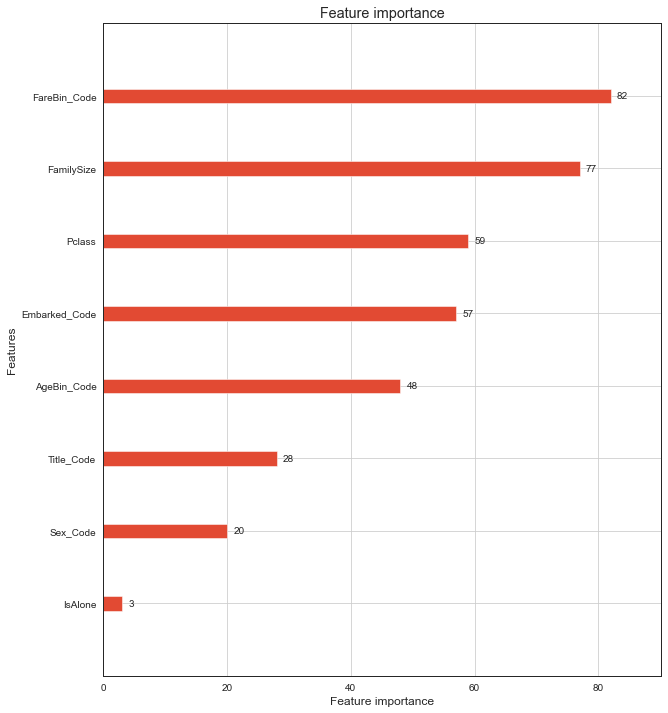

In [50]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
lgbm_class=LGBMClassifier(n_estimators=500,max_depth=128, min_child_samples=60, 
               num_leaves=32, subsample=0.8)
plot_importance(lgbm_wrapper, ax=ax)